In [3]:
# Classes
class Individual:
	def __init__(self, ind_id):
		self.id = ind_id
		self.vcf_index = None

	def __repr__(self):
		return '%s' % self.id

class Family:
	
	def __init__(self):
		self.id_to_index = dict()
		self.child_to_parents = dict() # child_id -> (mother_id, father_id)
		self.members = []

	def find_or_add_individual(self, ind_id):
		if ind_id in self.id_to_index:
			return self.members[self.id_to_index[ind_id]]
		else:
			ind = Individual(ind_id)
			self.id_to_index[ind_id] = len(self.members)
			self.members.append(ind)
			return ind
	
	def add_trio(self, child_id, mother_id, father_id):
		child = self.find_or_add_individual(child_id)
		mother = self.find_or_add_individual(mother_id)
		father = self.find_or_add_individual(father_id)

		self.child_to_parents[child_id] = (mother_id, father_id)

	def add_vcf_index(self, ind_id, vcf_index):
		if ind_id in self.id_to_index:
			self.members[self.id_to_index[ind_id]].vcf_index = vcf_index

	def order(self):
		trio = list(self.child_to_parents.items())[0]
		order = [self.id_to_index[trio[1][0]], self.id_to_index[trio[1][1]], self.id_to_index[trio[0]]] 
		order = order + [self.id_to_index[m.id] for m in self.members if self.id_to_index[m.id] not in order]
		return order

In [34]:
import numpy as np

# Mappings
mendelian_inheritance_map = {
    (0, 0): {0},
    (0, 1): {0, 1},
    (0, 2): {1},
    (1, 0): {0, 1},
    (1, 1): {0, 1, 2},
    (1, 2): {1, 2},
    (2, 0): {1},
    (2, 1): {1, 2},
    (2, 2): {2}
}

phase_map = {
    (0, 0, 0): (0, 0, 0, 0),
    (0, 0, 1): (-1, -1, -1, -1), # non-mendelian
    (0, 0, 2): (-1, -1, -1, -1), # non-mendelian
    (0, 1, 0): (0, 0, 0, 1),
    (0, 1, 1): (0, 0, 1, 0),
    (0, 1, 2): (-1, -1, -1, -1), # non-mendelian
    (0, 2, 0): (-1, -1, -1, -1), # non-mendelian
    (0, 2, 1): (0, 0, 1, 1),
    (0, 2, 2): (-1, -1, -1, -1), # non-mendelian
    (1, 0, 0): (0, 1, 0, 0),
    (1, 0, 1): (1, 0, 0, 0),
    (1, 0, 2): (-1, -1, -1, -1), # non-mendelian
    (1, 1, 0): (0, 1, 0, 1),
    (1, 1, 1): (-1, -1, -1, -1), # unknown phase
    (1, 1, 2): (1, 0, 1, 0),
    (1, 2, 0): (-1, -1, -1, -1), # non-mendelian
    (1, 2, 1): (0, 1, 1, 1),
    (1, 2, 2): (1, 0, 1, 1),
    (2, 0, 0): (-1, -1, -1, -1), # non-mendelian
    (2, 0, 1): (1, 1, 0, 0),
    (2, 0, 2): (-1, -1, -1, -1), # non-mendelian
    (2, 1, 0): (-1, -1, -1, -1), # non-mendelian
    (2, 1, 1): (1, 1, 0, 1),
    (2, 1, 2): (1, 1, 1, 0),
    (2, 2, 0): (-1, -1, -1, -1), # non-mendelian
    (2, 2, 1): (-1, -1, -1, -1), # non-mendelian
    (2, 2, 2): (1, 1, 1, 1),
}


Full dataset (6, 110820)


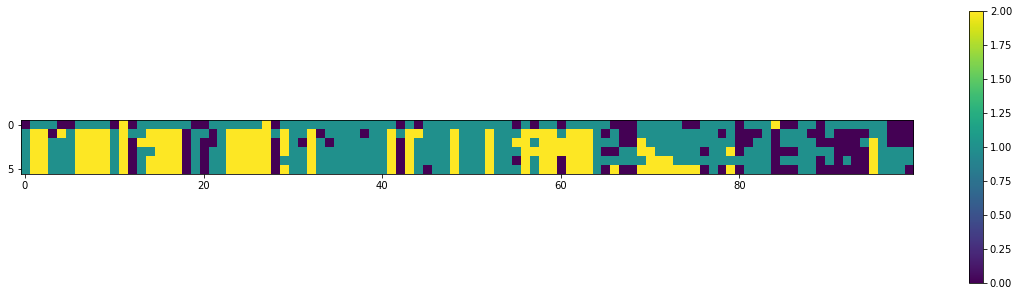

In [35]:
# load data
import time
import gzip
import matplotlib.pyplot as plt

# Pull arguments
vcf_file = 'AU0678.ms1.22.vcf.gz'
ped_file = 'v34.forCompoundHet.ped'
family_id = 'AU0678'

start_time = time.time()

# Pull family structure from ped file
family = Family()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, father_id, mother_id = pieces[0:4]
        if fam_id == family_id:
            family.add_trio(child_id, mother_id, father_id)

# Pull data from vcf
with gzip.open(vcf_file, 'rt') as f:
    line = next(f)
    while line.startswith('##'):
        line = next(f)

    # Pull header
    pieces = line.strip().split('\t')
    for i, ind_id in enumerate(pieces[9:]):
        family.add_vcf_index(ind_id, i+9)
    line = next(f)
    
    # Load genotypes into numpy arrays
    n = len(family.members)
    gen_mapping = {b'./.': -1, b'0/0': 0, b'0/1': 1, b'1/0': 1, b'1/1': 2}
    converter = lambda gen:gen_mapping[gen[:3]]
    vcf_indices = sorted([x.vcf_index for x in family.members if x.vcf_index is not None])
    data = np.loadtxt(f, dtype=np.int8, converters=dict(zip(vcf_indices, [converter]*n)), delimiter='\t', usecols=vcf_indices).T

print('Full dataset', data.shape)
plt.figure(figsize=(20,5))
heatmap = plt.imshow(np.abs(data[:, :100]))
plt.colorbar(heatmap)
plt.show()


In [36]:
import numpy as np

# Remove rows with missing entries
data = data[:, (data!=-1).all(axis=0)]
print('Remove missing entries', data.shape)

# Remove non-mendelian rows
#is_mendelian = np.apply_along_axis(lambda x: set(x[2:]).issubset(mendelian_inheritance_map[(x[0], x[1])]), 0, data)
#data = data[:, is_mendelian]
#print('Remove non-mendelian entries', data.shape)

# Remove only heterozygous site
data = data[:, ~(data==1).all(axis=0)]
print('Remove only heterozygous entries', data.shape)

# Subsection
#data = data[:, 30000:35000]

# Rough phase
phased = np.apply_along_axis(lambda x: phase_map[tuple(x)], 0, data[:3, :])
print(data)
print(phased)

Remove missing entries (6, 103938)
Remove only heterozygous entries (6, 99174)
[[0 1 1 ..., 1 1 2]
 [1 2 2 ..., 0 1 2]
 [1 2 2 ..., 0 1 2]
 [1 2 2 ..., 1 0 2]
 [1 2 2 ..., 1 0 2]
 [1 2 2 ..., 1 1 2]]
[[ 0  1  1 ...,  0 -1  1]
 [ 0  0  0 ...,  1 -1  1]
 [ 1  1  1 ...,  0 -1  1]
 [ 0  1  1 ...,  0 -1  1]]


In [8]:
import cvxpy as cvx

m, n = data.shape
k = 4
A = data
Y_init = phased[:4, :].astype(float)

# Ensure same initial random Y, rather than generate new one
# when executing this cell.
Y = Y_init

# Perform alternating minimization.
MAX_ITERS = 10
residual = np.zeros(MAX_ITERS)
for iter_num in range(1, 1+MAX_ITERS):
    # At the beginning of an iteration, X and Y are NumPy
    # array types, NOT CVXPY variables.

    # For odd iterations, treat Y constant, optimize over X.
    if iter_num % 2 == 1:
        X = cvx.Variable(m, k)
        
        B = np.array([[1, 1, 0, 0], [0, 0, 1, 1]])
        C = np.array([[2, 0], [0, 2]])
        print(B, C)
        #, X*B.T == C
        constraint = [X >= 0, X <= 1]
    # For even iterations, treat X constant, optimize over Y.
    else:
        Y = cvx.Variable(k, n)
        constraint = [Y >= 0]

    # Solve the problem.
    obj = cvx.Minimize(cvx.norm(A - X*Y, 1))
    prob = cvx.Problem(obj, constraint)
    prob.solve(solver=cvx.SCS)

    if prob.status != cvx.OPTIMAL:
        raise Exception("Solver did not converge!")

    print('Iteration {}, residual norm {}'.format(iter_num, prob.value))
    residual[iter_num-1] = prob.value

    # Convert variable to NumPy array constant for next iteration.
    if iter_num % 2 == 1:
        X = X.value
    else:
        Y = Y.value
        
X_round = (X >= 0.5).astype(int)
Y_round = (Y >= 0.5).astype(int)

[[1 1 0 0]
 [0 0 1 1]] [[2 0]
 [0 2]]
Failure:Interrupted


KeyError: 'Interrupted'

In [ ]:
import cvxpy as cvx
m, n = data.shape
k = 4
Y = np.apply_along_axis(lambda x: phase_map[tuple(x)], 0, data[:3, :])
W = cvx.Variable(n, k)
print(n, k, Y.shape)
obj = cvx.Minimize(cvx.norm(data[3, :] - cvx.trace(W*Y), 'fro'))
constraint = [W >= 0, W <= 1]
prob = cvx.Problem(obj, constraint)
prob.solve(solver=cvx.SCS)
print(W.value)

In [37]:
from itertools import product

def decompose(A, X=None):
    m, n = A.shape
    k = 4
    
    if X is None:
        # Rough phase (Y)
        Y = np.apply_along_axis(lambda x: phase_map[tuple(x)], 0, A[:3, :])

        # Update X
        X = np.zeros((m, k))
        X[0, 0] = X[0, 1] = 1
        X[1, 2] = X[1, 3] = 1
        X[2, 0] = X[2, 2] = 1

        possible_combinations = [(0, 2), (0, 3), (1, 2), (1, 3)]
        possible_genotypes = np.zeros((4, n))
        for i, combo in enumerate(possible_combinations):
            possible_genotypes[i, :] = Y[combo[0], :] + Y[combo[1], :]

        scores = [None]*m
        scores[0] = np.sum(np.abs(A[0, :]-(Y[0, :] + Y[1, :])))
        scores[1] = np.sum(np.abs(A[1, :]-(Y[2, :] + Y[3, :])))
        scores[2] = np.sum(np.abs(A[2, :]-(Y[0, :] + Y[2, :])))

        for j in range(3, m):
            for i, combo in enumerate(possible_combinations):
                new_score = np.sum(np.abs(A[j, :]-possible_genotypes[i, :]))

                if scores[j] is None or new_score < scores[j]:
                    X[j, :] = np.zeros(4)
                    X[j, combo[0]] = X[j, combo[1]] = 1
                    scores[j] = new_score
        #print(X, scores)
    else:
        Y = np.zeros((k, n))

    # Update Y
    all_combinations = np.array(list(product([0, 1], repeat=4))).T
    all_possible = X.dot(all_combinations)
    #print(all_combinations)
    #print(all_possible)
    for i in range(n):
        #print(A[:, i])
        d = np.sum(np.abs(np.outer(A[:, i], np.ones(16))-all_possible), axis=0)
        #print(d)
        Y[:, i] = all_combinations[:, np.argmin(d, axis=0)]
    #print(Y)

    return X, Y, scores

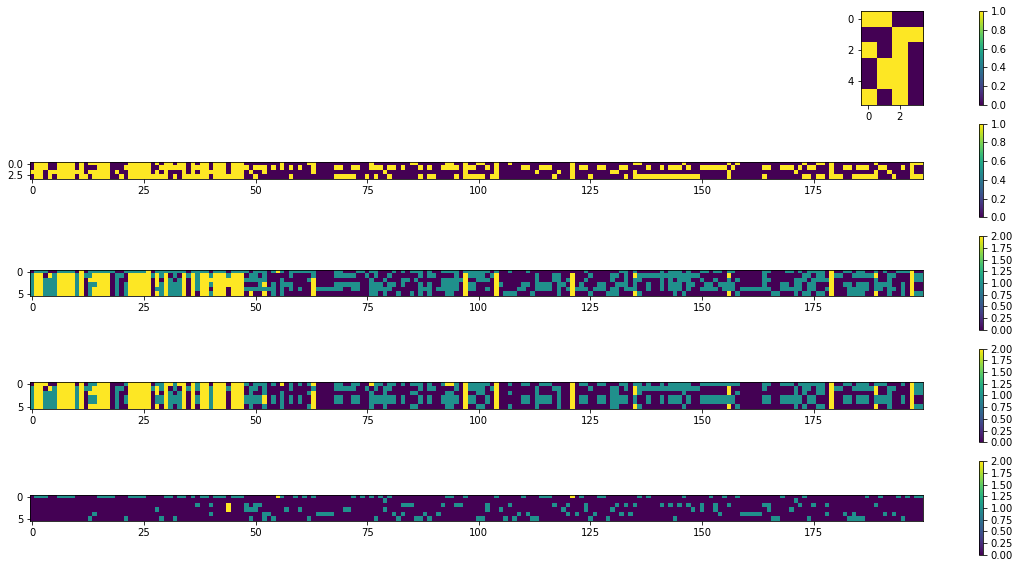

In [38]:
X_round, Y_round, scores1 = decompose(data)

start, end = 0, 200
plt.figure(figsize=(20,10))
plt.subplot(5, 1, 1)
heatmap = plt.imshow(X_round)
plt.colorbar(heatmap)
plt.subplot(5, 1, 2)
heatmap = plt.imshow(Y_round[:, start:end])
plt.colorbar(heatmap)
plt.subplot(5, 1, 3)
heatmap = plt.imshow(data[:, start:end])
plt.colorbar(heatmap)
plt.subplot(5, 1, 4)
heatmap = plt.imshow(X_round.dot(Y_round)[:, start:end])
plt.colorbar(heatmap)
plt.subplot(5, 1, 5)
heatmap = plt.imshow(np.abs(X_round.dot(Y_round)-data)[:, start:end])
plt.colorbar(heatmap)
plt.show()

0
5000
[[ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  1.  0.]]
5000
30000
[[ 1.  0.  1.  0.]
 [ 1.  0.  1.  0.]
 [ 1.  0.  1.  0.]]
30000
40000
[[ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 1.  0.  1.  0.]]
40000
55000
[[ 0.  1.  1.  0.]
 [ 0.  1.  0.  1.]
 [ 1.  0.  1.  0.]]
55000
65000
[[ 1.  0.  0.  1.]
 [ 0.  1.  1.  0.]
 [ 1.  0.  0.  1.]]
65000
70000
[[ 1.  0.  0.  1.]
 [ 0.  1.  1.  0.]
 [ 1.  0.  0.  1.]]
70000
90000
[[ 1.  0.  0.  1.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  0.  1.]]
90000
100000
[[ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  0.  1.]]


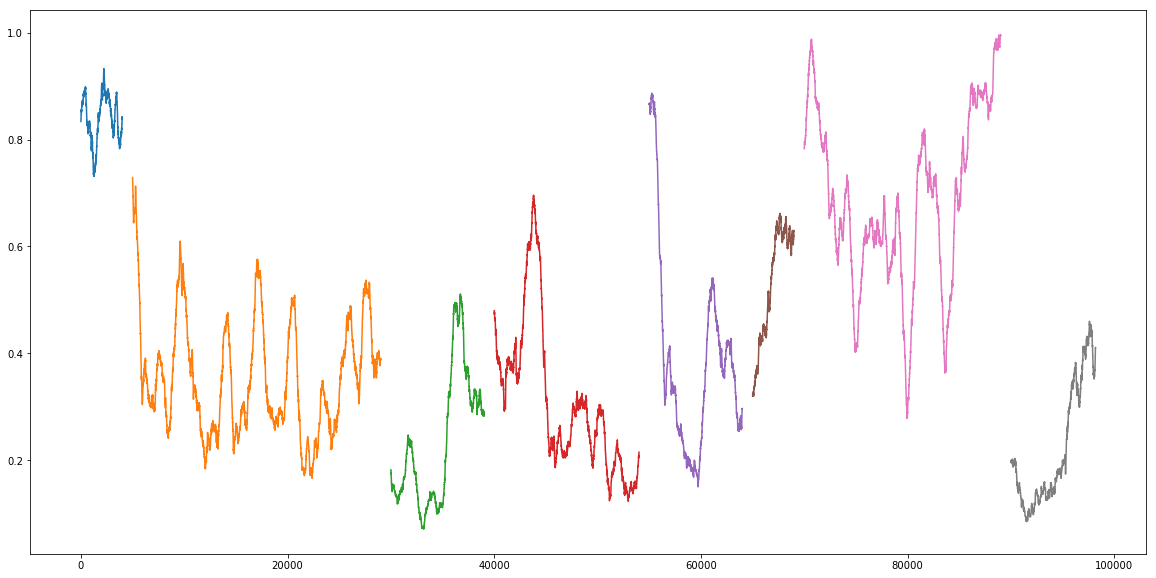

In [39]:
plt.figure(figsize=(20,10))

#X, Y, scores = decompose(data, X=np.array([[1, 1, 0, 0], [0, 0, 1, 1], []]))
#print(i, X[3:, :], sep='\n')
#errors = np.sum(np.abs(data - X.dot(Y)), axis=0)
#plt.plot(np.convolve(errors, np.ones((1000,))/1000, mode='valid'))

breaks = [0, 5000, 30000, 40000, 55000, 65000, 70000, 90000, 100000]
for i in range(1, len(breaks)):
    X, Y, scores = decompose(data[:, breaks[i-1]:breaks[i]])
    print(breaks[i-1], breaks[i], X[3:, :], sep='\n')
    errors = np.convolve(np.sum(np.abs(data[:, breaks[i-1]:breaks[i]] - X.dot(Y)), axis=0), np.ones((1000,))/1000, mode='valid')
    plt.plot(range(breaks[i-1], breaks[i-1]+errors.shape[0]), errors)

plt.show()

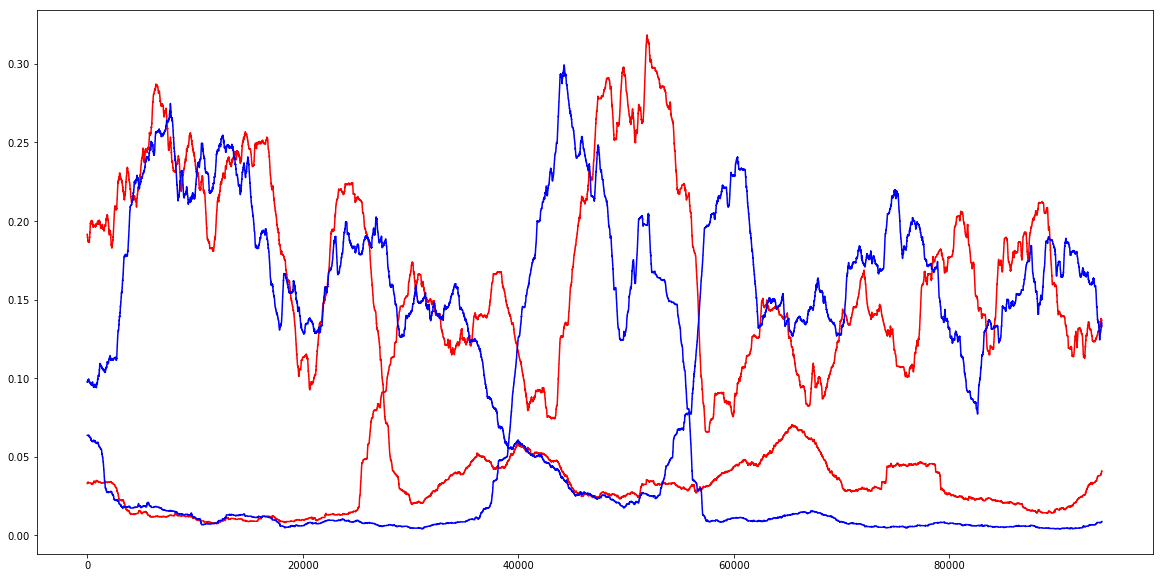

In [206]:
plt.figure(figsize=(20,10))
Y = np.apply_along_axis(lambda x: phase_map[tuple(x)], 0, data[:3, :])
comb = np.concatenate((data, Y), axis=0)
m, n = data.shape

cindex = 4
#comb = comb[:, comb[cindex, :] != 1]
child_strand1 = np.apply_along_axis(lambda x: 1 if (x[cindex] == 0 and x[m] == 1) or (x[cindex] == 2 and x[m] == 0) else 0, 0, comb)
child_strand2 = np.apply_along_axis(lambda x: 1 if (x[cindex] == 0 and x[m+1] == 1) or (x[cindex] == 2 and x[m+1] == 0) else 0, 0, comb)
child_strand3 = np.apply_along_axis(lambda x: 1 if (x[cindex] == 0 and x[m+2] == 1) or (x[cindex] == 2 and x[m+2] == 0) else 0, 0, comb)
child_strand4 = np.apply_along_axis(lambda x: 1 if (x[cindex] == 0 and x[m+3] == 1) or (x[cindex] == 2 and x[m+3] == 0) else 0, 0, comb)

q = 5000
plt.plot(np.convolve(child_strand1, np.ones((q,))/q, mode='valid'), c='red')
plt.plot(np.convolve(child_strand2, np.ones((q,))/q, mode='valid'), c='red')
plt.plot(np.convolve(child_strand3, np.ones((q,))/q, mode='valid'), c='blue')
plt.plot(np.convolve(child_strand4, np.ones((q,))/q, mode='valid'), c='blue')
plt.show()


In [171]:
def rough_phase(data, child_index=2):
    return np.apply_along_axis(lambda x: phase_map[(x[0], x[1], x[child_index])], 0, data)

def detect_recombination(data, Y, q=5000):
    m, n = data.shape
    X = np.zeros((m, 4, n))
    X[0, 0, :] = X[0, 1, :] = 1 # Mom always has m1, m2
    X[1, 2, :] = X[1, 3, :] = 1 # Dad always has p1, p2
    
    for i in range(2, m):
        # For each child
        child_strand1 = np.array([1 if (data[i, j] == 0 and Y[0, j] == 1) or (data[i, j] == 2 and Y[0, j] == 0) else 0 for j in range(n)])
        child_strand2 = np.array([1 if (data[i, j] == 0 and Y[1, j] == 1) or (data[i, j] == 2 and Y[1, j] == 0) else 0 for j in range(n)])
        child_strand3 = np.array([1 if (data[i, j] == 0 and Y[2, j] == 1) or (data[i, j] == 2 and Y[2, j] == 0) else 0 for j in range(n)])
        child_strand4 = np.array([1 if (data[i, j] == 0 and Y[3, j] == 1) or (data[i, j] == 2 and Y[3, j] == 0) else 0 for j in range(n)])

        conv_child_strand1 = np.convolve(child_strand1, np.ones((q,))/q, mode='same')
        conv_child_strand2 = np.convolve(child_strand2, np.ones((q,))/q, mode='same')
        conv_child_strand3 = np.convolve(child_strand3, np.ones((q,))/q, mode='same')
        conv_child_strand4 = np.convolve(child_strand4, np.ones((q,))/q, mode='same')
        
        X[i, 0, :] = conv_child_strand1 < conv_child_strand2
        X[i, 1, :] = 1-X[i, 0, :]
        X[i, 2, :] = conv_child_strand3 < conv_child_strand4
        X[i, 3, :] = 1-X[i, 2, :]
    return X

In [172]:
from itertools import product

def phase(data, X):
    all_combinations = np.array(list(product([0, 1], repeat=4))).T
    Y = np.zeros((4, n))
    for i in range(n):
        diff = np.outer(data[:, i], np.ones(all_combinations.shape[1])) - X[:, :, i].dot(all_combinations)
        index = np.argmin(np.sum(np.abs(diff), axis=0))
        Y[:, i] = all_combinations[:, index]

    return Y

def to_genotype(X, Y):
    m, _, n = X.shape
    genotype = np.zeros((m, n))
    for i in range(m):
        genotype[i, :] = np.sum(X[i, :, :]*Y, axis=0)
    return genotype

In [211]:
def polish_recombination_events(data, X, Y, allowable_errors=10):
    m, n = data.shape
    for j in range(2, m):
        maternal_recombinations = [0] + [i for i in range(n-1) if X[j, 0, i] != X[j, 0, i+1]] + [n-1]
        paternal_recombinations = [0] + [i for i in range(n-1) if X[j, 2, i] != X[j, 2, i+1]] + [n-1]
        print(maternal_recombinations)
        for mrec in maternal_recombinations:
            # try moving left
            new_pos = mrec
            num_errors = allowable_errors
            while new_pos >= 0 and num_errors >= 0:
                old_score = np.sum(np.abs((X[j, :, new_pos]*Y[:, new_pos]) - data[j, new_pos]))
                X[j, 0, new_pos] = 1 - X[j, 0, new_pos]
                X[j, 1, new_pos] = 1 - X[j, 1, new_pos]
                new_score = np.sum(np.abs((X[j, :, new_pos]*Y[:, new_pos]) - data[j, new_pos]))
                num_errors -= (new_score - old_score)
                new_pos -= 1
                
            # try moving right
            new_pos = mrec+1
            num_errors = allowable_errors
            while new_pos < n and num_errors >= 0:
                old_score = np.sum(np.abs((X[j, :, new_pos]*Y[:, new_pos]) - data[j, new_pos]))
                X[j, 0, new_pos] = 1 - X[j, 0, new_pos]
                X[j, 1, new_pos] = 1 - X[j, 1, new_pos]
                new_score = np.sum(np.abs((X[j, :, new_pos]*Y[:, new_pos]) - data[j, new_pos]))
                num_errors -= (new_score - old_score)
                new_pos += 1
         
        print(paternal_recombinations)
        for prec in paternal_recombinations:
            # try moving left
            new_pos = prec
            num_errors = allowable_errors
            while new_pos >= 0 and num_errors >= 0:
                old_score = np.sum(np.abs((X[j, :, new_pos]*Y[:, new_pos]) - data[j, new_pos]))
                X[j, 2, new_pos] = 1 - X[j, 2, new_pos]
                X[j, 3, new_pos] = 1 - X[j, 3, new_pos]
                new_score = np.sum(np.abs((X[j, :, new_pos]*Y[:, new_pos]) - data[j, new_pos]))
                num_errors -= (new_score - old_score)
                new_pos -= 1
                
            # try moving right
            new_pos = prec+1
            num_errors = allowable_errors
            while new_pos < n and num_errors >= 0:
                old_score = np.sum(np.abs((X[j, :, new_pos]*Y[:, new_pos]) - data[j, new_pos]))
                X[j, 0, new_pos] = 1 - X[j, 0, new_pos]
                X[j, 1, new_pos] = 1 - X[j, 1, new_pos]
                new_score = np.sum(np.abs((X[j, :, new_pos]*Y[:, new_pos]) - data[j, new_pos]))
                num_errors -= (new_score - old_score)
                new_pos += 1
    return X

In [290]:
from itertools import product, islice
def detect_recombination_dp(data, Y, switch_cost=50):
    m, n = data.shape
    X = np.zeros((m, 4, n))
    X[0, 0, :] = X[0, 1, :] = 1 # Mom always has m1, m2
    X[1, 2, :] = X[1, 3, :] = 1 # Dad always has p1, p2
    X[2, 0, :] = X[2, 2, :] = 1 # Child1 always has m1, p1
    
    # genotype possibilities for children
    # m1p1, m1p2, m2p1, m2p2
    Z = np.array([[1, 0, 1, 0], 
                  [1, 0, 0, 1], 
                  [0, 1, 1, 0], 
                  [0, 1, 0, 1]]).dot(Y)
    transition_costs = np.array([[0, 1, 1, 2],
                                 [1, 0, 2, 1],
                                 [1, 2, 0, 1],
                                 [2, 1, 1, 0]])*switch_cost
    index_to_indices = [(0, 2), (0, 3), (1, 2), (1, 3)]
    
    for i in range(3, m):
        # for each child
        
        # Forward sweep
        dp = [[(0, None)]*4]
        for j in range(n):
            gen = data[i, j]
            # consider cost of all 16 combinations
            possible_transitions = list(product(range(4), repeat=2))
            costs = [(dp[-1][k][0]+transition_costs[k, l]+abs(gen-Z[l, j]), k) for l, k in possible_transitions]
            dp.append([min(costs[:4]), min(costs[4:8]), min(costs[8:12]), min(costs[12:16])])
                
        #print(dp[:5])
        #print(dp[-5:])
        
        # Backward sweep
        index = n-1
        cost, prev = min(dp[index])
        X[i, index_to_indices[prev], index] = 1
        while prev is not None:
            X[i, index_to_indices[prev], index-1] = 1
            index -= 1
            _, prev = min(dp[index])
            
        #print(X[i, :, :])
    return X



In [296]:
Y0 = rough_phase(data)
X1 = detect_recombination_dp(data, Y0, switch_cost=50)
Y1 = phase(data, X1)
X2 = detect_recombination_dp(data, Y1, switch_cost=50)
Y2 = phase(data, X2)
X3 = detect_recombination_dp(data, Y2, switch_cost=50)
Y3 = phase(data, X3)

In [297]:
for j in range(m):
    print(j)
    maternal_recombinations = [0] + [i for i in range(n-1) if X3[j, 0, i] != X3[j, 0, i+1]] + [n-1]
    paternal_recombinations = [0] + [i for i in range(n-1) if X3[j, 2, i] != X3[j, 2, i+1]] + [n-1]
    print(maternal_recombinations)
    print(paternal_recombinations)

0
[0, 99173]
[0, 99173]
1
[0, 99173]
[0, 99173]
2
[0, 99173]
[0, 99173]
3
[0, 30291, 55539, 79541, 99173]
[0, 163, 3629, 3631, 3640, 4398, 4770, 24187, 24268, 57897, 85194, 99173]
4
[0, 30287, 79116, 79543, 99173]
[0, 186, 3527, 4434, 4452, 4475, 4760, 41716, 57891, 99173]
5
[0, 4402, 4539, 27979, 30282, 79543, 99173]
[0, 4681, 4743, 57902, 99173]


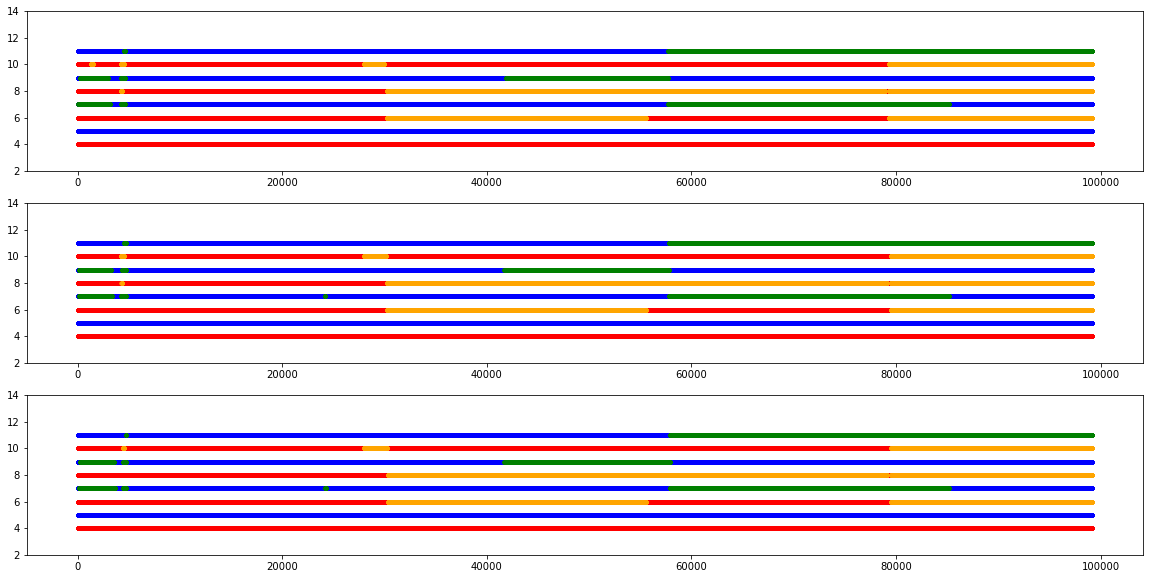

In [299]:
plt.figure(figsize=(20,10))

show = [X1, X2, X3]

for k, X in enumerate(show):
    plt.subplot(len(show), 1, k+1)
    for i in range(2, m):
        plt.plot(2*i*X[i, 0, :], linestyle='None', marker='.', color='red')
        plt.plot(2*i*X[i, 1, :], linestyle='None', marker='.', color='orange')
        plt.plot(2*i*X[i, 2, :]+1, linestyle='None', marker='.', color='blue')
        plt.plot(2*i*X[i, 3, :]+1, linestyle='None', marker='.', color='green')
    
    axes = plt.gca()
    axes.set_ylim([2,(m+1)*2])

plt.show()

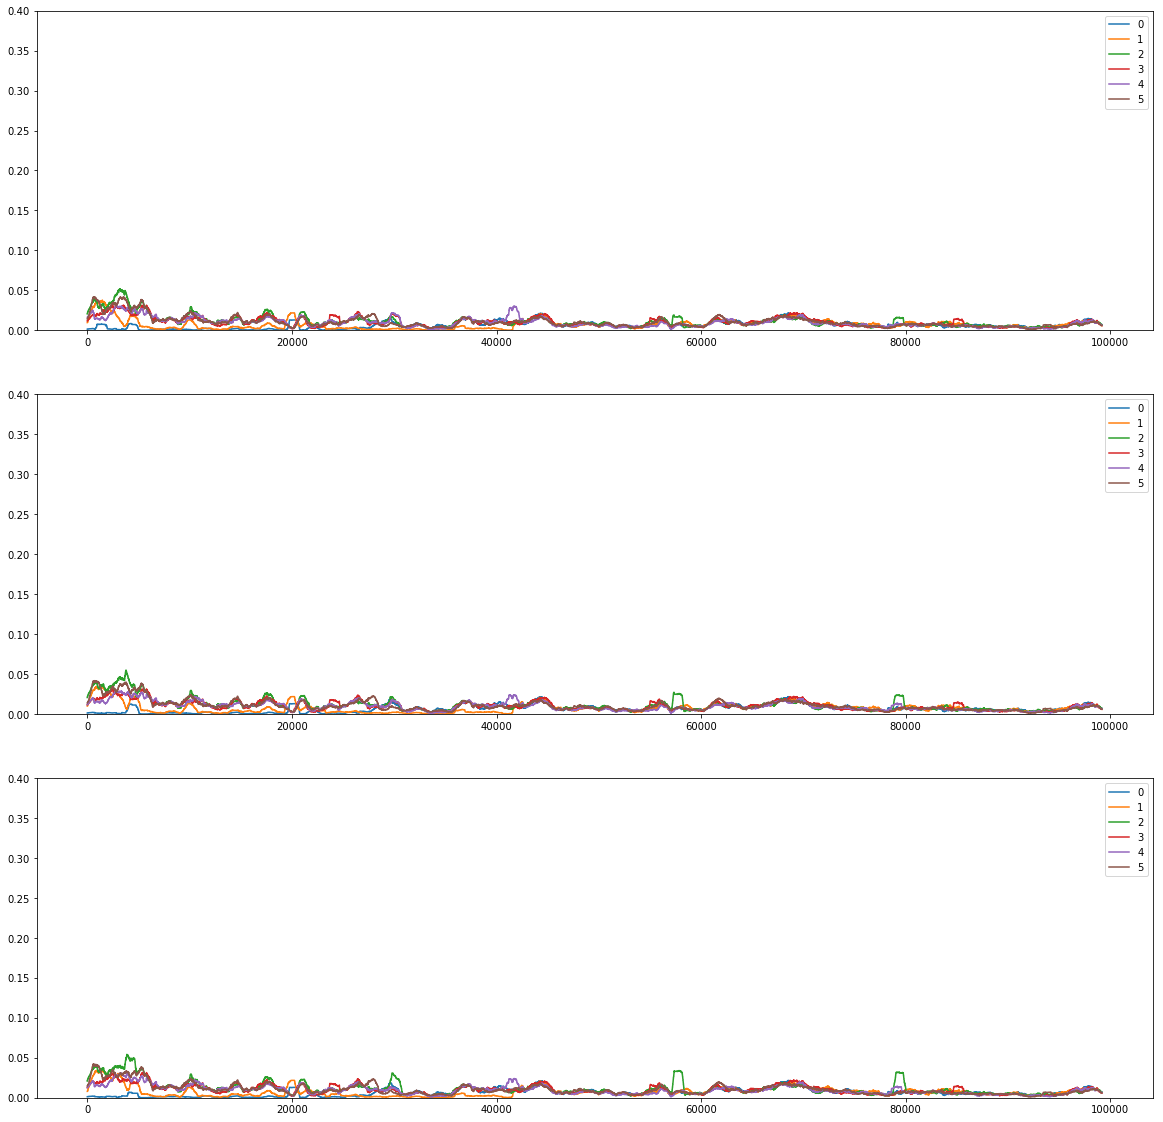

In [301]:
q = 1000
plt.figure(figsize=(20,20))

show = [(X1, Y1), (X2, Y2), (X3, Y3)]

for k, (X, Y) in enumerate(show):
    plt.subplot(len(show), 1, k+1)
    #plt.plot(np.convolve(np.sum(np.abs(to_genotype(X1, Y1)-data), axis=0)/m, np.ones((q,))/q, mode='same'))
    for i in range(m):
        plt.plot(np.convolve(np.abs(to_genotype(X, Y)-data)[i, :], np.ones((q,))/(q*m), mode='same'), label=str(i))
    axes = plt.gca()
    axes.set_ylim([0, .4])
    plt.legend()
plt.show()

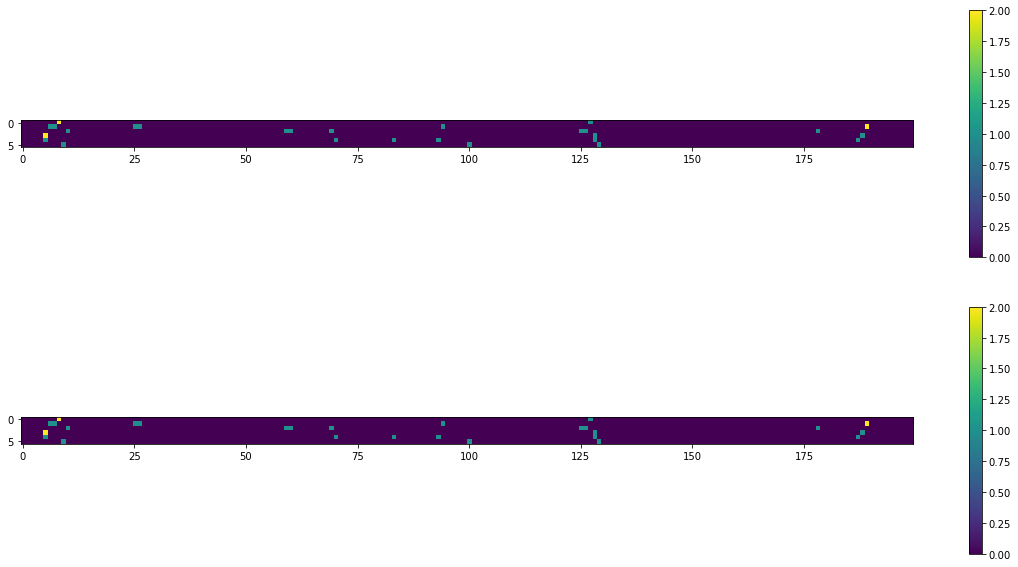

In [302]:
start, end = 60000, 60200
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
heatmap = plt.imshow(np.abs(to_genotype(X1, Y1)-data)[:, start:end])
plt.colorbar(heatmap)
plt.subplot(2, 1, 2)
heatmap = plt.imshow(np.abs(to_genotype(X2, Y2)-data)[:, start:end])
plt.colorbar(heatmap)
plt.show()

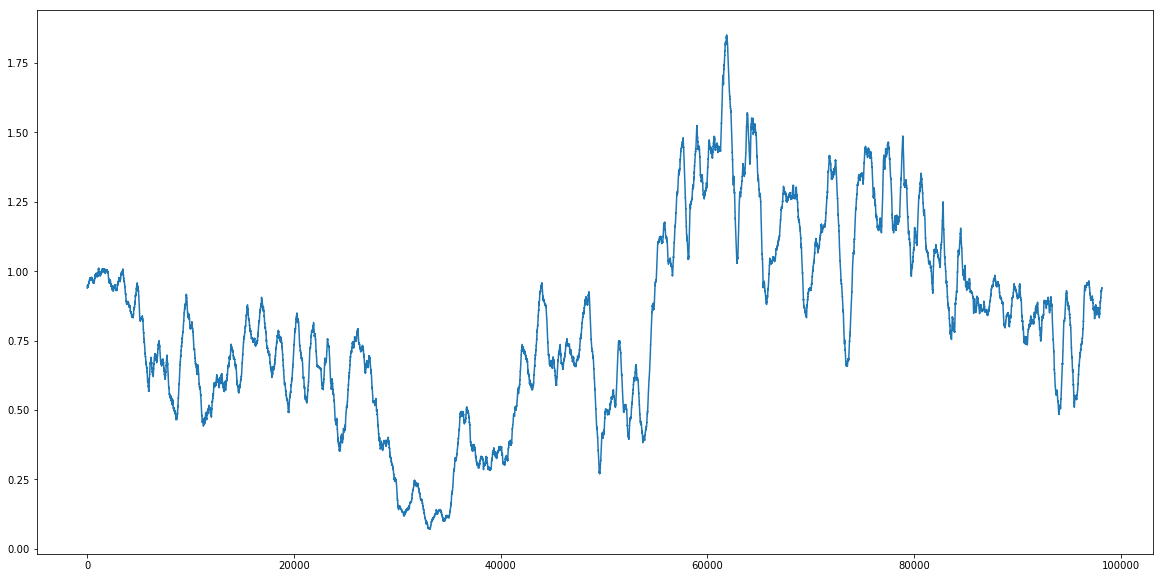

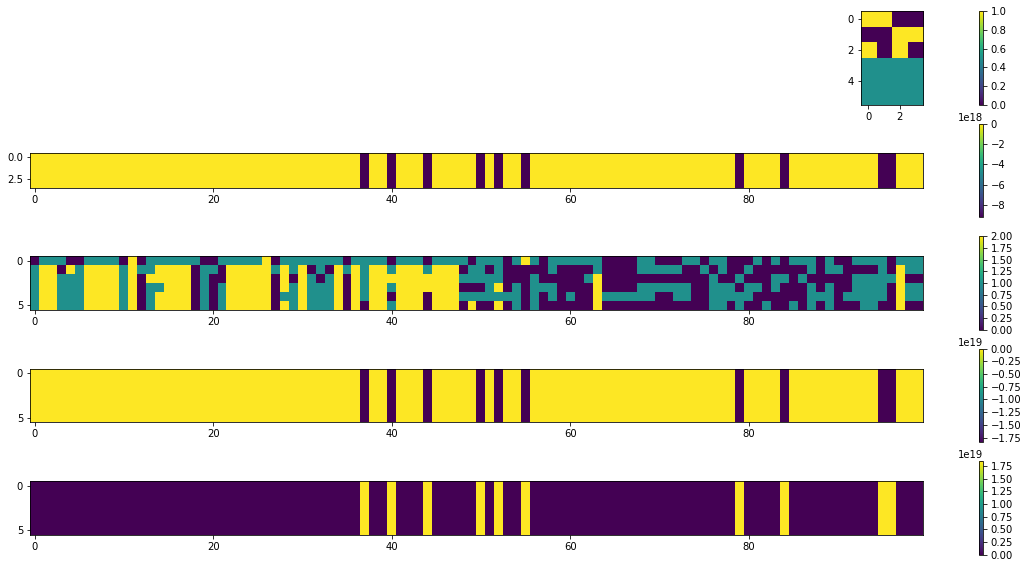

In [59]:
from sklearn.decomposition import NMF

pre_W = np.zeros((data.shape[0], 4))
pre_W[0, 0] = 1
pre_W[0, 1] = 1
pre_W[1, 2] = 1
pre_W[1, 3] = 1
pre_W[2, 0] = 1
pre_W[2, 2] = 1
for i in range(3, data.shape[0]):
    for j in range(0, 4):
        pre_W[i, j] = 0.5

W = (pre_W[:, :4]).copy()
H = (phased[:4, :]).astype(float)
#print(W.shape, H.shape)

#model = NMF(n_components=4, init='custom', solver='cd')
#W = model.fit_transform(data, W=W, H=H)
#H = model.components_

# Update W
#W = np.linalg.solve(H.dot(H.T), H.dot(data.T)).T
#W[W < 0] = 0
#W[W > 1] = 1
#W[0, 0] = 1
#W[0, 1] = 1
#W[1, 2] = 1
#W[1, 3] = 1
#W[2, 0] = 1
#W[2, 2] = 1

# Update H
#H = np.linalg.solve(W.T.dot(W), W.T.dot(data))
#H[H < 0] = 0
#H[H > 1] = 1

plt.figure(figsize=(20,10))
plt.subplot(5, 1, 1)
heatmap = plt.imshow(W)
plt.colorbar(heatmap)
plt.subplot(5, 1, 2)
heatmap = plt.imshow(H[:, :100])
plt.colorbar(heatmap)
plt.subplot(5, 1, 3)
heatmap = plt.imshow(data[:, :100])
plt.colorbar(heatmap)
plt.subplot(5, 1, 4)
heatmap = plt.imshow(np.round(np.minimum(W.dot(H), 2))[:, :100])
plt.colorbar(heatmap)
plt.subplot(5, 1, 5)
heatmap = plt.imshow(np.abs(np.round(np.minimum(W.dot(H), 2))-data)[:, :100])
plt.colorbar(heatmap)
plt.show()

[[  1.87780119e-02   3.48407320e+00   0.00000000e+00   0.00000000e+00]
 [  9.30256970e-03   0.00000000e+00   8.32155548e-03   3.43215270e+00]
 [  0.00000000e+00   2.71230704e-03   3.51340257e+00   0.00000000e+00]
 [  2.14113809e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.13133142e+00   1.31434786e-02   0.00000000e+00   0.00000000e+00]
 [  1.80701125e+00   4.52838801e-02   4.47328753e-01   2.72042482e-02]]


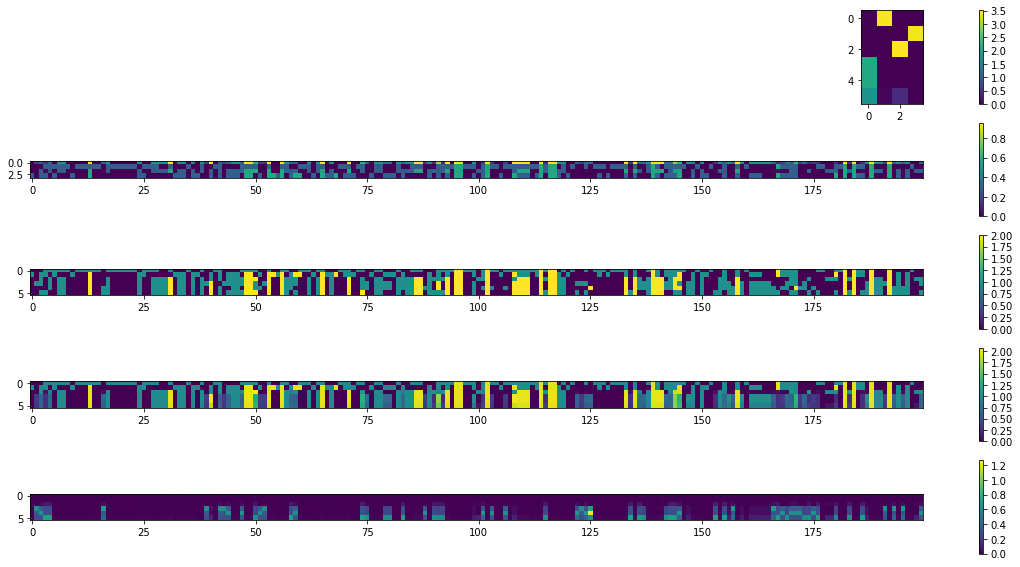

In [260]:
print(W)
plt.figure(figsize=(20,10))
plt.subplot(5, 1, 1)
heatmap = plt.imshow(W)
plt.colorbar(heatmap)
plt.subplot(5, 1, 2)
heatmap = plt.imshow(H[:, :200])
plt.colorbar(heatmap)
plt.subplot(5, 1, 3)
heatmap = plt.imshow(data[:, :200])
plt.colorbar(heatmap)
plt.subplot(5, 1, 4)
heatmap = plt.imshow(W.dot(H)[:, :200])
plt.colorbar(heatmap)
plt.subplot(5, 1, 5)
heatmap = plt.imshow(np.abs(W.dot(H)-data)[:, :200])
plt.colorbar(heatmap)
plt.show()

[15980  1323  7887  4302  4912  1915  1853    57    31  1740]


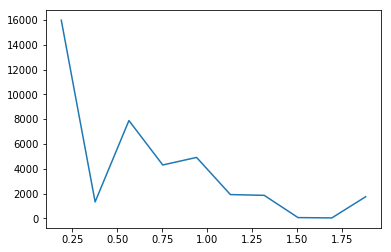

In [234]:
x, y = np.histogram(H)
print(x)
plt.plot(y[1:], x)
plt.show()

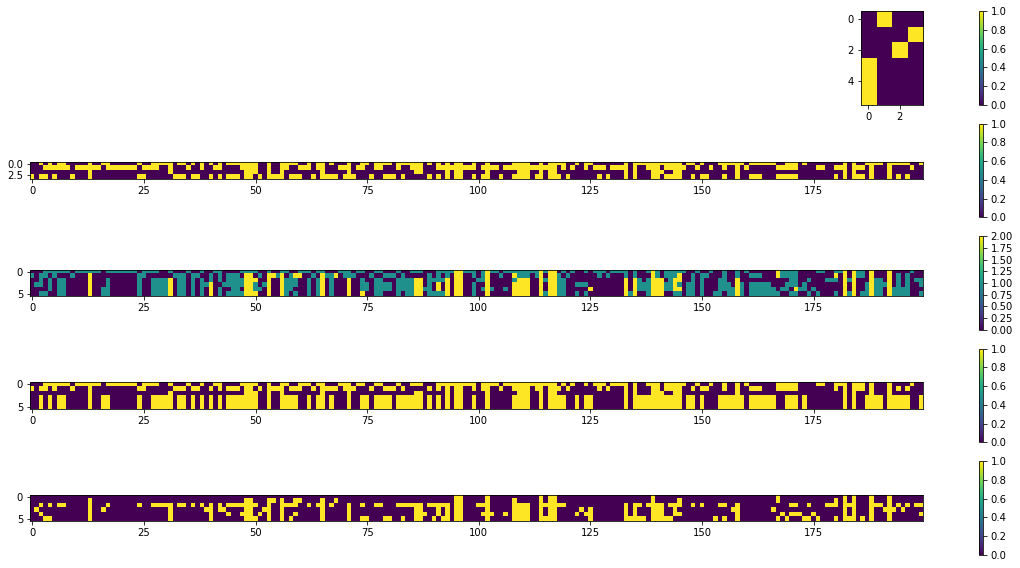

In [237]:
new_h = np.round(H)
new_w = np.round(W)
new_h[new_h>1] = 1
new_w[new_w>1] = 1
plt.figure(figsize=(20,10))
plt.subplot(5, 1, 1)
heatmap = plt.imshow(new_w)
plt.colorbar(heatmap)
plt.subplot(5, 1, 2)
heatmap = plt.imshow(new_h[:, :200])
plt.colorbar(heatmap)
plt.subplot(5, 1, 3)
heatmap = plt.imshow(data[:, :200])
plt.colorbar(heatmap)
plt.subplot(5, 1, 4)
heatmap = plt.imshow(new_w.dot(new_h)[:, :200])
plt.colorbar(heatmap)
plt.subplot(5, 1, 5)
heatmap = plt.imshow(np.abs(new_w.dot(new_h)-data)[:, :200])
plt.colorbar(heatmap)
plt.show()

In [205]:
model = NMF(n_components=4, init='custom')
W = model.fit_transform(normal_data, W=new_w, H=new_H)
H = model.components_

NameError: name 'new_W' is not defined